**RESTO DE LOS PASOS**
4- Construir la matriz término-clase con las clases disponibles en 20 Newsgroups y con estos embeddings de palabras resultantes explorar similaridad entre términos.
5- Construir la matriz término-término utilizando una ventana de contexto. Para construir esta matriz serán útiles las funcionalidades de Keras make_sampling_table, skipgrams y el tokenizador de Keras. Explorar resultados de similaridad de términos con diferentes tamaños de contexto.
6- Con la matriz término-término construir la matriz de PPMI y factorizarla aplicando truncated SVD. Explorar resultados de similaridad término a término.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt


newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

PASO 4

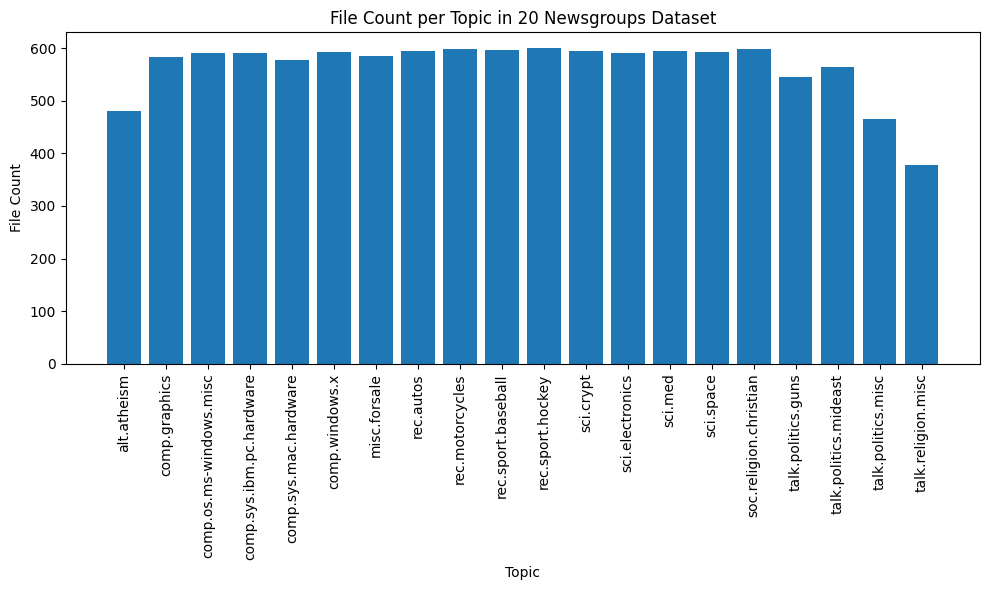

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# Crear un DataFrame para el conteo de archivos por tema
data = {'Topic': newsgroups.target_names, 'File Count': [0] * len(newsgroups.target_names)}
df = pd.DataFrame(data)

# Contar los archivos por tema
for target in newsgroups.target:
    df.loc[target, 'File Count'] += 1

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df['Topic'], df['File Count'])
plt.xticks(rotation=90)
plt.xlabel('Topic')
plt.ylabel('File Count')
plt.title('File Count per Topic in 20 Newsgroups Dataset')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [3]:
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_df=0.25, min_df=100, stop_words="english")
TNG_count = count_vectorizer.fit_transform(newsgroups.data)
terms = count_vectorizer.get_feature_names_out()

In [6]:
# Crear una matriz de recuento de términos por categoría
term_counts = np.zeros((len(terms), len(newsgroups.target_names)))

# Llenar la matriz con los conteos de términos por categoría
for doc_idx, target_idx in zip(TNG_count.nonzero()[0], TNG_count.nonzero()[1]):
    term_counts[target_idx, newsgroups.target[doc_idx]] += TNG_count[doc_idx, target_idx]

# Imprimir la matriz de recuento de términos por categoría
print(term_counts)

[[  0.  26.  18. ...   7.  15.   1.]
 [ 17.  12.   3. ... 145.  53.   9.]
 [  5.  54.  39. ...  59.  58.  22.]
 ...
 [ 49.  29.  25. ...  62.  95.  35.]
 [  4.   9.   0. ...  51.  32.   4.]
 [ 16.   1.   2. ...  64.  63.  13.]]


In [28]:
from sklearn.neighbors import NearestNeighbors
word_queque=["space", "science", "god", "car", "women"]
neighbor = NearestNeighbors(n_neighbors=20, metric="cosine").fit(term_counts)

In [30]:
# Encontrar las palabras más relacionadas e imprimir
for word in word_queque:
        word_idx = count_vectorizer.vocabulary_[word]
        _, neigh = neighbor.kneighbors(term_counts[word_idx, :].reshape(1, -1))
        vocab = count_vectorizer.get_feature_names_out()
        print("Sample:", word)
        print(vocab[neigh[0]])


Sample: space
['space' 'nasa' 'station' 'dc' 'earth' 'vehicle' 'project' 'surface'
 'development' 'mass' 'commercial' 'engineering' 'cost' 'institute'
 'design' 'material' 'center' 'costs' 'cheaper' 'sci']
Sample: science
['science' 'theory' 'scientific' 'significant' 'research' 'dr' 'caused'
 'studies' 'eventually' 'age' 'results' 'references' 'taking' 'natural'
 'practice' 'effects' 'causes' 'alternative' 'highly' 'weight']
Sample: god
['god' 'christianity' 'faith' 'lord' 'christians' 'truth' 'beliefs'
 'jesus' 'bible' 'christian' 'church' 'christ' 'hell' 'love' 'nature'
 'existence' 'exists' 'meaning' 'paul' 'life']
Sample: car
['car' 'cars' 'driving' 'dealer' 'engine' 'miles' 'road' 'bought'
 'replaced' 'models' 'buying' 'fun' 'owners' 'speed' 'track' 'gas' 'deal'
 'door' 'sounds' 'looks']
Sample: women
['women' 'brought' 'killing' 'said' 'peace' 'told' 'lived' 'woman'
 'history' 'happened' 'couldn' 'population' 'forces' 'anti' 'wife'
 'jewish' 'turned' 'saw' 'started' 'came']


In [31]:
# Obtener las palabras más frecuentes por categoría
top_words_per_topic = []
for topic_idx in range(len(newsgroups.target_names)):
    topic_word_indices = np.argsort(term_counts[:, topic_idx])[::-1]
    top_words = [vocab[idx] for idx in topic_word_indices[:10]]
    top_words_per_topic.append(top_words)

# Imprimir las palabras más frecuentes por categoría
for topic_idx, top_words in enumerate(top_words_per_topic):
    topic_name = newsgroups.target_names[topic_idx]
    print(f"Top words for '{topic_name}': {', '.join(top_words)}")

Top words for 'alt.atheism': god, people, don, think, just, does, say, believe, like, religion
Top words for 'comp.graphics': image, graphics, edu, file, use, data, files, software, images, program
Top words for 'comp.os.ms-windows.misc': windows, file, 34, use, dos, files, using, problem, like, 14
Top words for 'comp.sys.ibm.pc.hardware': drive, scsi, card, disk, controller, drives, use, ide, bus, hard
Top words for 'comp.sys.mac.hardware': mac, apple, drive, use, problem, like, know, does, bit, just
Top words for 'comp.windows.x': file, window, use, program, server, edu, motif, output, available, set
Top words for 'misc.forsale': 00, new, sale, 50, 10, dos, offer, shipping, 20, price
Top words for 'rec.autos': car, cars, like, just, don, good, new, engine, know, think
Top words for 'rec.motorcycles': bike, just, like, don, know, good, time, think, right, new
Top words for 'rec.sport.baseball': year, game, good, team, think, don, 00, just, like, games
Top words for 'rec.sport.hockey':

paso 5

In [2]:
from keras.preprocessing.sequence import make_sampling_table, skipgrams
from keras.preprocessing.text import Tokenizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix,lil_matrix
from matplotlib import pyplot as plt
import numpy as np

In [6]:
V = 10001
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(newsgroups.data)
seqs=tokenizer.texts_to_sequences(newsgroups.data)
counts_matrix=lil_matrix((V-1, V-1))

In [7]:
seqs=np.hstack(seqs)
seqs=seqs.astype(int)
data, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=5, negative_samples=0, sampling_table=make_sampling_table(V, sampling_factor=1e-3), shuffle=False)


In [8]:
pairs, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=5, negative_samples=0, sampling_table=make_sampling_table(V, sampling_factor=1), shuffle=False)
pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)
len(pairs_u)

4127751

In [9]:
for num,(pair,count) in enumerate(zip(pairs_u, counts)):
    if num%1000 ==0:
        print(f'\r{num}', end="")
    counts_matrix[pair[0],pair[1]] += count

4127000

In [10]:
red = TruncatedSVD(n_components=100)
TNG_cv_red = red.fit_transform(counts_matrix)
TNG_cv_red.shape

(10000, 100)

In [11]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_cv_red)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                 radius=1.0)
tokenizer.word_index["car"]

312

In [12]:
idx_1 = tokenizer.word_index["women"]
_, neig = neigh.kneighbors(TNG_cv_red[idx_1:idx_1+1])
for n in neig[0]:
    print(tokenizer.index_word[n])

women
both
families
girls
others
houses
practices
children
villages
smoking
politicians
doctors
terrorists
skills
violence
communities
industries
measures
education
persecution


paso 6

In [13]:
counts_matrix

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4127751 stored elements in List of Lists format>

In [14]:
PMI = counts_matrix[1:,1:].sum(axis=1)/counts_matrix[1:,1:].sum()
PMI.shape
probs = counts_matrix[1:,1:]/counts_matrix[1:,1:].sum()
PMI = probs/np.dot(PMI, PMI.T)

In [15]:
PMI

matrix([[ 1.06095759,  0.        ,  1.1426377 , ...,  0.        ,
          0.        ,  0.12686257],
        [ 0.        , 28.21111072,  0.        , ...,  1.95645454,
          1.52168686,  1.30430303],
        [ 1.14691982,  0.        ,  0.87349361, ...,  0.        ,
          0.50697236,  0.        ],
        ...,
        [ 0.        ,  1.95645454,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  1.52168686,  0.50697236, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.12686257,  1.30430303,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [16]:
PMI=np.array(PMI)
PMI

array([[ 1.06095759,  0.        ,  1.1426377 , ...,  0.        ,
         0.        ,  0.12686257],
       [ 0.        , 28.21111072,  0.        , ...,  1.95645454,
         1.52168686,  1.30430303],
       [ 1.14691982,  0.        ,  0.87349361, ...,  0.        ,
         0.50697236,  0.        ],
       ...,
       [ 0.        ,  1.95645454,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.52168686,  0.50697236, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.12686257,  1.30430303,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
PMI=PMI*(PMI>1)+1e-8
PMI = np.log(PMI)
PMI=PMI*(PMI>0)+1e-8
PMI

array([[5.91719073e-02, 1.00000000e-08, 1.33339380e-01, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 3.33971591e+00, 1.00000000e-08, ...,
        6.71133942e-01, 4.19819516e-01, 2.65668837e-01],
       [1.37079950e-01, 1.00000000e-08, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       ...,
       [1.00000000e-08, 6.71133942e-01, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 4.19819516e-01, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08],
       [1.00000000e-08, 2.65668837e-01, 1.00000000e-08, ...,
        1.00000000e-08, 1.00000000e-08, 1.00000000e-08]])

In [18]:
red = TruncatedSVD(n_components=100)
TNG_cv_red = red.fit_transform(PMI)

In [19]:
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_cv_red)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [20]:
idx_1 = tokenizer.word_index["women"]
_, neig = neigh.kneighbors(TNG_cv_red[idx_1:idx_1+1])
for n in neig[0]:
    print(tokenizer.index_word[n])

women
especially
christ
internet
unix
word
easier
16
best
free
actually
pretty
similar
let
political
per
everyone
small
purpose
better


# CONCLUSIONES:

1.   

*     El cambio de dimensionalidad que hay entre TF-IDF y Count Vectorizer afecta sustancialmente el tiempo de computo al usar TSNE, pero en el resto son similares los metodos.

*    Trigramas ~= Bigramas > unigramas

*    Depende MUCHO de la palabra que busques, los resultados estan estrechamente relacionados a que tantos tópicos puede pertenecer. 'car' meh, women weird results.
2.  Resultados raros, casi que erroneos. Bajo el cálculo pero los resultados de las categorías no suelen corresponder entre textos.
3.  El grafico proporcionado al final (confeccionado a partir del código de cátedra) es accurate. Dan bastante cercanos las palabras relacionadas. Estan cerca de cada muestra, como debería ser.
4.  Se realizo una EDA para saber sobre qué se trabajaba. Si una palabra es "multi-categorías" los resultados son muy variados, en cambio si son muy particulares como el nombre de una ciudad, encuentra buenos resultados.
5.  Se intento aumentar la ventana, pero crasheaba el collab por el costo computacional. Sin embargo como resultado de investigación, se encontro un sitio de Kaggle con proyectos sobre el dataset de 20 NewsGroups, donde al tener una ventana >=5 se obtenian resultados óptimos para similitud entre palabras. Es decir, como se espera de la teoría, la relación entre palabras se vuelve cada vez más estrecha a medida que crece la ventana.
6.  Nada mas odiable que intentar hacer PPMI, no se busca camuflar el descontento por intentar correr esta parte del código. El error común era porque se dividía por 0, pese a que no encontraba un elemento en 0. Sin cambios en el código, se dio RunAll y se soluciona solo. La caja negra de GoogleCollab y la magia de NLP decidió que ande. Queda para consultas en clase, mientras que se considera un resultado bueno gracias a la correspondencia entre palabras, en mayor o menor medida. Honestamente, es de conformidad para el autor el hecho de que haya funcionado.

